In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [2]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [3]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [4]:
print(m_ml, b_ml, lnf_ml)

-0.957440191559 4.40835752633 -0.598964243111


In [5]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [6]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [7]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [8]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [9]:
sampler.run_mcmc(pos, 500)

(array([[-0.97270868,  4.41382382, -0.69871085],
        [-1.07460698,  4.89693944, -0.709323  ],
        [-0.93126498,  4.26273025, -0.58830149],
        [-1.02236964,  4.56497119, -0.81763088],
        [-0.83301562,  3.74670483, -0.45762944],
        [-0.88283137,  4.08260829, -0.41792357],
        [-0.95177159,  4.34418688, -0.55065829],
        [-1.02498978,  4.94438924, -0.6520969 ],
        [-1.05164109,  4.81096545, -0.62800209],
        [-1.01469099,  4.72563283, -0.59328894],
        [-1.03193131,  4.64048989, -0.65628173],
        [-0.90126621,  4.1623327 , -0.5079001 ],
        [-1.08578677,  5.09517458, -0.54936285],
        [-0.97494896,  4.29570713, -0.44070107],
        [-1.02117793,  4.67847329, -0.5217898 ],
        [-1.0719248 ,  4.97439718, -0.64624273],
        [-0.90699193,  4.06188608, -0.71961238],
        [-0.9434017 ,  4.52660521, -0.60580427],
        [-1.00663079,  4.6736008 , -0.47104869],
        [-0.84686755,  3.75043966, -0.33020526],
        [-1.04136898

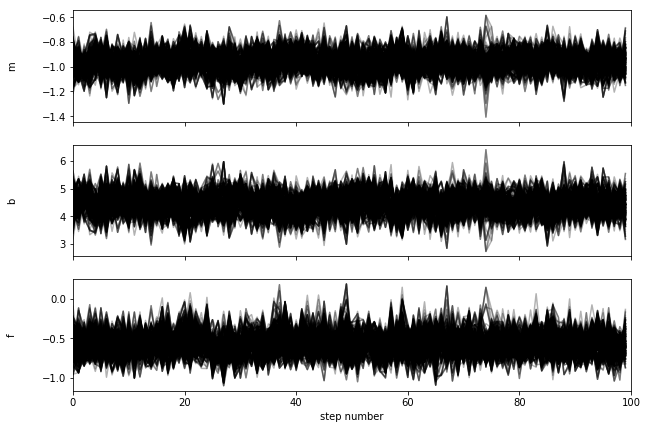

In [10]:
plt.figure(1)
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [11]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [12]:
import corner
plt.figure(2)
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"], truths=[m_true, b_true, np.log(f_true)])
fig.savefig("test.png")